# Sequence-to-Sequence LSTM for Multi-Day Ice Extent Forecasting

This notebook extends single-step prediction to multi-step forecasting. Instead of predicting 1 day ahead, we predict the next 7 days.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from src.data_utils import load_data

## Seq2Seq Dataset Class

Key difference from previous notebooks: y is now a sequence of forecast_horizon timesteps instead of a single value.

In [2]:
class Seq2SeqArcticDataset(torch.utils.data.Dataset):

    def __init__(self, data, sequence_length=30, forecast_horizon=7, features=None, target='extent_mkm2', scaler=None, add_cyclical_time=False):
        self.data = data.sort_values('date').reset_index(drop=True)
        self.sequence_length = sequence_length
        self.forecast_horizon = forecast_horizon
        self.target = target
        
        if features is None:
            self.features = ['extent_mkm2']
        else:
            self.features = features.copy()
        
        if add_cyclical_time:
            day_of_year = pd.to_datetime(self.data['date']).dt.dayofyear
            self.data['day_of_year_sin'] = np.sin(2 * np.pi * day_of_year / 365.25)
            self.data['day_of_year_cos'] = np.cos(2 * np.pi * day_of_year / 365.25)
            self.features.extend(['day_of_year_sin', 'day_of_year_cos'])
        
        self.data_values = self.data[self.features].values.astype(np.float32)
        
        self.target_idx = self.features.index(self.target)
        
        if scaler is None:
            self.mean = self.data_values.mean(axis=0, keepdims=True)
            self.std = self.data_values.std(axis=0, keepdims=True)
            self.std = np.where(self.std == 0, 1.0, self.std)
        else:
            self.mean, self.std = scaler
        
        self.data_normalized = (self.data_values - self.mean) / self.std
    
    def __len__(self):
        return len(self.data_normalized) - self.sequence_length - self.forecast_horizon + 1
    
    def __getitem__(self, idx):
        X = self.data_normalized[idx:idx + self.sequence_length]
        
        y = self.data_normalized[idx + self.sequence_length:idx + self.sequence_length + self.forecast_horizon, self.target_idx]
        
        X = torch.tensor(X, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        
        return X, y

## Load Data

In [3]:
train_data = load_data(regions='pan_arctic', years=range(1989, 2020))
test_data = load_data(regions='pan_arctic', years=range(2020, 2024))

print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Training data shape: (11322, 27)
Test data shape: (1461, 27)


## Seq2Seq LSTM Model

Output layer now produces forecast_horizon predictions instead of 1.

In [4]:
class Seq2SeqIceExtentLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, forecast_horizon=7, dropout=0.2):
        super(Seq2SeqIceExtentLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.forecast_horizon = forecast_horizon
        
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        self.fc = nn.Linear(hidden_size, forecast_horizon)
    
    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, (h_n, c_n) = self.lstm(x, (h_0, c_0))
        
        out = self.fc(out[:, -1, :])
        
        return out

## Univariate Seq2Seq (Ice Extent Only)

In [5]:
train_dataset_uni = Seq2SeqArcticDataset(
    train_data,
    sequence_length=30,
    forecast_horizon=7,
    features=['extent_mkm2'],
    target='extent_mkm2'
)

test_dataset_uni = Seq2SeqArcticDataset(
    test_data,
    sequence_length=30,
    forecast_horizon=7,
    features=['extent_mkm2'],
    target='extent_mkm2',
    scaler=(train_dataset_uni.mean, train_dataset_uni.std)
)

train_loader_uni = torch.utils.data.DataLoader(train_dataset_uni, batch_size=32, shuffle=True)
test_loader_uni = torch.utils.data.DataLoader(test_dataset_uni, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset_uni)}")
print(f"Test samples: {len(test_dataset_uni)}")

for X_batch, y_batch in train_loader_uni:
    print(f"\nBatch X shape: {X_batch.shape} (batch, seq_len, features)")
    print(f"Batch y shape: {y_batch.shape} (batch, forecast_horizon)")
    break

Training samples: 11286
Test samples: 1425

Batch X shape: torch.Size([32, 30, 1]) (batch, seq_len, features)
Batch y shape: torch.Size([32, 7]) (batch, forecast_horizon)


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model_uni = Seq2SeqIceExtentLSTM(
    input_size=1,
    hidden_size=80,
    num_layers=2,
    forecast_horizon=7,
    dropout=0.2
)
model_uni = model_uni.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_uni.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

print(f"Model parameters: {sum(p.numel() for p in model_uni.parameters()):,}")

In [7]:
num_epochs = 200
best_val_loss = float('inf')
patience = 15
patience_counter = 0

train_losses_uni = []
val_losses_uni = []

print("Starting training...\n")
for epoch in range(num_epochs):
    model_uni.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader_uni:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        predictions = model_uni(X_batch)
        loss = criterion(predictions, y_batch)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_uni.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_uni)

    model_uni.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader_uni:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model_uni(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader_uni)

    train_losses_uni.append(avg_train_loss)
    val_losses_uni.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {avg_train_loss:.6f}')
        print(f'  Val Loss: {avg_val_loss:.6f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model_uni.state_dict(), 'best_seq2seq_univariate.pt')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print(f"\nTraining complete! Best validation loss: {best_val_loss:.6f}")

Starting training...

Epoch 5/200
  Train Loss: 0.004071
  Val Loss: 0.003676
Epoch 10/200
  Train Loss: 0.003058
  Val Loss: 0.002916
Epoch 15/200
  Train Loss: 0.002592
  Val Loss: 0.003405
Epoch 20/200
  Train Loss: 0.002338
  Val Loss: 0.002211
Epoch 25/200
  Train Loss: 0.002169
  Val Loss: 0.002845
Epoch 30/200
  Train Loss: 0.001942
  Val Loss: 0.001872
Epoch 35/200
  Train Loss: 0.001917
  Val Loss: 0.001787
Epoch 40/200
  Train Loss: 0.001925
  Val Loss: 0.002310
Epoch 45/200
  Train Loss: 0.001780
  Val Loss: 0.001882
Epoch 50/200
  Train Loss: 0.001635
  Val Loss: 0.001606
Epoch 55/200
  Train Loss: 0.001553
  Val Loss: 0.001607
Epoch 60/200
  Train Loss: 0.001547
  Val Loss: 0.001460
Epoch 65/200
  Train Loss: 0.001444
  Val Loss: 0.001512

Early stopping at epoch 69

Training complete! Best validation loss: 0.001419


## Multivariate Seq2Seq (Ice Extent + Climate Variables)

In [8]:
features = [
    'extent_mkm2',
    't2m_mean',
    't2m_std',
    'msl_mean',
    'msl_std',
    'wind_speed_mean',
    'wind_speed_std',
]

In [9]:
train_dataset_multi = Seq2SeqArcticDataset(
    train_data,
    sequence_length=30,
    forecast_horizon=7,
    features=features,
    target='extent_mkm2'
)

test_dataset_multi = Seq2SeqArcticDataset(
    test_data,
    sequence_length=30,
    forecast_horizon=7,
    features=features,
    target='extent_mkm2',
    scaler=(train_dataset_multi.mean, train_dataset_multi.std)
)

train_loader_multi = torch.utils.data.DataLoader(train_dataset_multi, batch_size=32, shuffle=True)
test_loader_multi = torch.utils.data.DataLoader(test_dataset_multi, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset_multi)}")
print(f"Test samples: {len(test_dataset_multi)}")
print(f"Number of features: {len(features)}")

Training samples: 11286
Test samples: 1425
Number of features: 7


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model_multi = Seq2SeqIceExtentLSTM(
    input_size=len(features),
    hidden_size=64,
    num_layers=2,
    forecast_horizon=7,
    dropout=0.2
)
model_multi = model_multi.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_multi.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

print(f"Model parameters: {sum(p.numel() for p in model_multi.parameters()):,}")

Using device: cpu
Model parameters: 52,423


In [11]:
num_epochs = 200
best_val_loss = float('inf')
patience = 15
patience_counter = 0

train_losses_multi = []
val_losses_multi = []

print("Starting training...\n")
for epoch in range(num_epochs):
    model_multi.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader_multi:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        predictions = model_multi(X_batch)
        loss = criterion(predictions, y_batch)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_multi.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_multi)

    model_multi.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader_multi:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model_multi(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader_multi)

    train_losses_multi.append(avg_train_loss)
    val_losses_multi.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {avg_train_loss:.6f}')
        print(f'  Val Loss: {avg_val_loss:.6f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model_multi.state_dict(), 'best_seq2seq_multivariate.pt')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print(f"\nTraining complete! Best validation loss: {best_val_loss:.6f}")

Starting training...

Epoch 5/200
  Train Loss: 0.003486
  Val Loss: 0.003500
Epoch 10/200
  Train Loss: 0.002733
  Val Loss: 0.003046
Epoch 15/200
  Train Loss: 0.002380
  Val Loss: 0.002397
Epoch 20/200
  Train Loss: 0.002212
  Val Loss: 0.002456
Epoch 55/200
  Train Loss: 0.001214
  Val Loss: 0.001876

Early stopping at epoch 57

Training complete! Best validation loss: 0.001631


## Multivariate + Cyclical Time Encoding

In [12]:
train_dataset_cyc = Seq2SeqArcticDataset(
    train_data,
    sequence_length=30,
    forecast_horizon=7,
    features=features,
    target='extent_mkm2',
    add_cyclical_time=True
)

test_dataset_cyc = Seq2SeqArcticDataset(
    test_data,
    sequence_length=30,
    forecast_horizon=7,
    features=features,
    target='extent_mkm2',
    scaler=(train_dataset_cyc.mean, train_dataset_cyc.std),
    add_cyclical_time=True
)

train_loader_cyc = torch.utils.data.DataLoader(train_dataset_cyc, batch_size=32, shuffle=True)
test_loader_cyc = torch.utils.data.DataLoader(test_dataset_cyc, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_dataset_cyc)}")
print(f"Test samples: {len(test_dataset_cyc)}")
print(f"Number of features: {len(train_dataset_cyc.features)}")

Training samples: 11286
Test samples: 1425
Number of features: 9


In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

model_cyc = Seq2SeqIceExtentLSTM(
    input_size=len(train_dataset_cyc.features),
    hidden_size=64,
    num_layers=2,
    forecast_horizon=7,
    dropout=0.2
)
model_cyc = model_cyc.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model_cyc.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

print(f"Model parameters: {sum(p.numel() for p in model_cyc.parameters()):,}")

Using device: cpu
Model parameters: 52,935


In [ ]:
num_epochs = 200
best_val_loss = float('inf')
patience = 15
patience_counter = 0

train_losses_cyc = []
val_losses_cyc = []

print("Starting training...\n")
for epoch in range(num_epochs):
    model_cyc.train()
    train_loss = 0.0

    for X_batch, y_batch in train_loader_cyc:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        predictions = model_cyc(X_batch)
        loss = criterion(predictions, y_batch)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_cyc.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader_cyc)

    model_cyc.eval()
    val_loss = 0.0

    with torch.no_grad():
        for X_batch, y_batch in test_loader_cyc:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            predictions = model_cyc(X_batch)
            loss = criterion(predictions, y_batch)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(test_loader_cyc)

    train_losses_cyc.append(avg_train_loss)
    val_losses_cyc.append(avg_val_loss)

    scheduler.step(avg_val_loss)

    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{num_epochs}')
        print(f'  Train Loss: {avg_train_loss:.6f}')
        print(f'  Val Loss: {avg_val_loss:.6f}')

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model_cyc.state_dict(), 'best_seq2seq_cyclical.pt')
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break

print(f"\nTraining complete! Best validation loss: {best_val_loss:.6f}")

Starting training...



## Compare Model Predictions

Visualize how each model performs on random weeks from 2024 test data.

In [15]:
model_uni.load_state_dict(torch.load('best_seq2seq_univariate.pt'))
model_multi.load_state_dict(torch.load('best_seq2seq_multivariate.pt'))
model_cyc.load_state_dict(torch.load('best_seq2seq_cyclical.pt'))

model_uni.eval()
model_multi.eval()
model_cyc.eval()

extent_idx_uni = 0
extent_idx_multi = features.index('extent_mkm2')
extent_idx_cyc = train_dataset_cyc.features.index('extent_mkm2')

extent_mean_uni = train_dataset_uni.mean[0, extent_idx_uni]
extent_std_uni = train_dataset_uni.std[0, extent_idx_uni]

extent_mean_multi = train_dataset_multi.mean[0, extent_idx_multi]
extent_std_multi = train_dataset_multi.std[0, extent_idx_multi]

extent_mean_cyc = train_dataset_cyc.mean[0, extent_idx_cyc]
extent_std_cyc = train_dataset_cyc.std[0, extent_idx_cyc]

print("Models loaded and ready for comparison")

Models loaded and ready for comparison


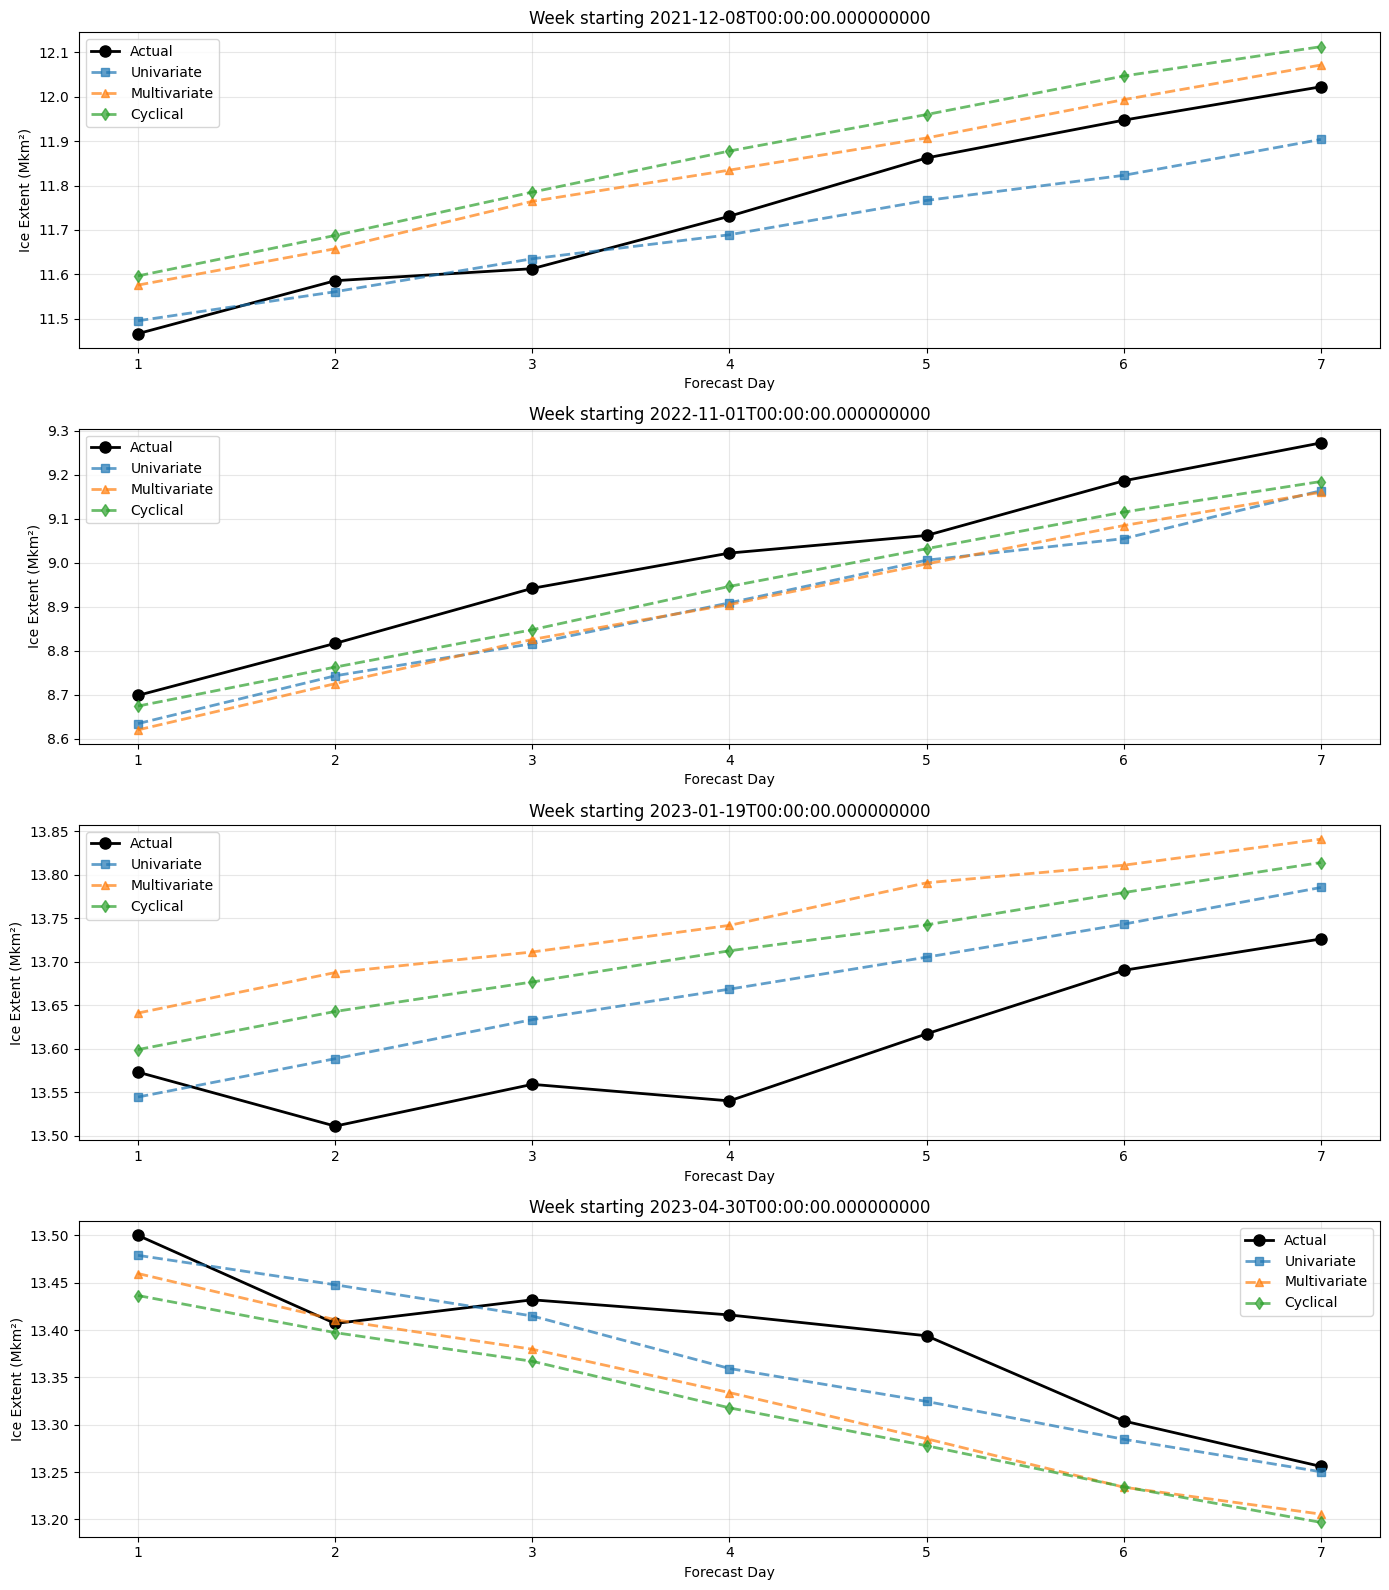

In [16]:
np.random.seed(42)
num_weeks = 4

test_dates = test_data['date'].values
min_valid_idx = 30
max_valid_idx = len(test_dates) - 7

random_start_indices = np.random.choice(range(min_valid_idx, max_valid_idx), num_weeks, replace=False)
random_start_indices = np.sort(random_start_indices)

fig, axes = plt.subplots(num_weeks, 1, figsize=(14, 4 * num_weeks))

for plot_idx, start_idx in enumerate(random_start_indices):
    
    week_dates = test_dates[start_idx:start_idx + 7]
    
    X_uni, y_uni = test_dataset_uni[start_idx - 30]
    X_multi, y_multi = test_dataset_multi[start_idx - 30]
    X_cyc, y_cyc = test_dataset_cyc[start_idx - 30]
    
    with torch.no_grad():
        pred_uni = model_uni(X_uni.unsqueeze(0).to(device)).cpu().numpy()[0]
        pred_multi = model_multi(X_multi.unsqueeze(0).to(device)).cpu().numpy()[0]
        pred_cyc = model_cyc(X_cyc.unsqueeze(0).to(device)).cpu().numpy()[0]
    
    actual_uni = y_uni.numpy()
    actual_multi = y_multi.numpy()
    actual_cyc = y_cyc.numpy()
    
    pred_uni_orig = pred_uni * extent_std_uni + extent_mean_uni
    pred_multi_orig = pred_multi * extent_std_multi + extent_mean_multi
    pred_cyc_orig = pred_cyc * extent_std_cyc + extent_mean_cyc
    actual_orig = actual_uni * extent_std_uni + extent_mean_uni
    
    ax = axes[plot_idx] if num_weeks > 1 else axes
    
    days = np.arange(1, 8)
    ax.plot(days, actual_orig, 'ko-', label='Actual', linewidth=2, markersize=8)
    ax.plot(days, pred_uni_orig, 's--', label='Univariate', alpha=0.7, linewidth=2)
    ax.plot(days, pred_multi_orig, '^--', label='Multivariate', alpha=0.7, linewidth=2)
    ax.plot(days, pred_cyc_orig, 'd--', label='Cyclical', alpha=0.7, linewidth=2)
    
    ax.set_xlabel('Forecast Day')
    ax.set_ylabel('Ice Extent (Mkm²)')
    ax.set_title(f'Week starting {week_dates[0]}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xticks(days)

plt.tight_layout()
plt.show()

## Error by Forecast Day

Analyze how prediction error accumulates across the 7-day forecast horizon.

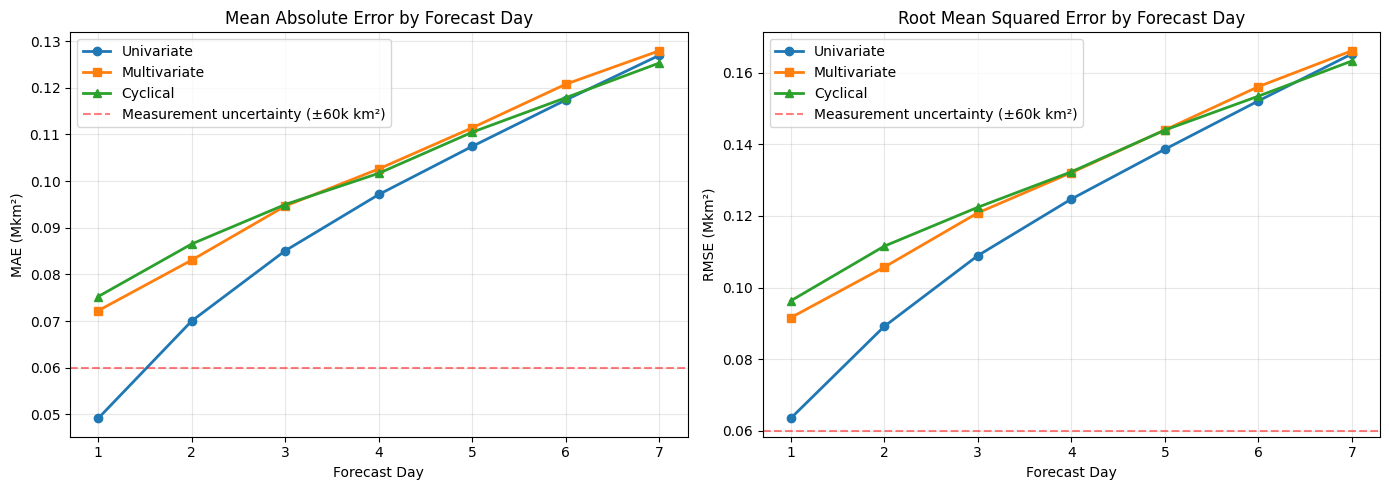

\nMAE by forecast day (Mkm²):
Day      Univariate  Multivariate  Cyclical
Day 1    0.0491      0.0722        0.0752
Day 2    0.0700      0.0831        0.0865
Day 3    0.0851      0.0947        0.0950
Day 4    0.0971      0.1026        0.1017
Day 5    0.1075      0.1114        0.1105
Day 6    0.1174      0.1208        0.1179
Day 7    0.1270      0.1280        0.1253
\nRMSE by forecast day (Mkm²):
Day      Univariate  Multivariate  Cyclical
Day 1    0.0635      0.0916        0.0963
Day 2    0.0891      0.1057        0.1115
Day 3    0.1089      0.1208        0.1224
Day 4    0.1247      0.1321        0.1323
Day 5    0.1386      0.1440        0.1439
Day 6    0.1521      0.1561        0.1534
Day 7    0.1652      0.1661        0.1632


In [17]:
errors_by_day_uni = [[] for _ in range(7)]
errors_by_day_multi = [[] for _ in range(7)]
errors_by_day_cyc = [[] for _ in range(7)]

with torch.no_grad():
    for i in range(len(test_dataset_uni)):
        X_uni, y_uni = test_dataset_uni[i]
        X_multi, y_multi = test_dataset_multi[i]
        X_cyc, y_cyc = test_dataset_cyc[i]
        
        pred_uni = model_uni(X_uni.unsqueeze(0).to(device)).cpu().numpy()[0]
        pred_multi = model_multi(X_multi.unsqueeze(0).to(device)).cpu().numpy()[0]
        pred_cyc = model_cyc(X_cyc.unsqueeze(0).to(device)).cpu().numpy()[0]
        
        actual_uni = y_uni.numpy()
        actual_multi = y_multi.numpy()
        actual_cyc = y_cyc.numpy()
        
        pred_uni_orig = pred_uni * extent_std_uni + extent_mean_uni
        pred_multi_orig = pred_multi * extent_std_multi + extent_mean_multi
        pred_cyc_orig = pred_cyc * extent_std_cyc + extent_mean_cyc
        actual_orig = actual_uni * extent_std_uni + extent_mean_uni
        
        for day in range(7):
            errors_by_day_uni[day].append(abs(pred_uni_orig[day] - actual_orig[day]))
            errors_by_day_multi[day].append(abs(pred_multi_orig[day] - actual_orig[day]))
            errors_by_day_cyc[day].append(abs(pred_cyc_orig[day] - actual_orig[day]))

mae_by_day_uni = [np.mean(errors_by_day_uni[day]) for day in range(7)]
mae_by_day_multi = [np.mean(errors_by_day_multi[day]) for day in range(7)]
mae_by_day_cyc = [np.mean(errors_by_day_cyc[day]) for day in range(7)]

rmse_by_day_uni = [np.sqrt(np.mean([e**2 for e in errors_by_day_uni[day]])) for day in range(7)]
rmse_by_day_multi = [np.sqrt(np.mean([e**2 for e in errors_by_day_multi[day]])) for day in range(7)]
rmse_by_day_cyc = [np.sqrt(np.mean([e**2 for e in errors_by_day_cyc[day]])) for day in range(7)]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

days = np.arange(1, 8)

ax1.plot(days, mae_by_day_uni, 'o-', label='Univariate', linewidth=2)
ax1.plot(days, mae_by_day_multi, 's-', label='Multivariate', linewidth=2)
ax1.plot(days, mae_by_day_cyc, '^-', label='Cyclical', linewidth=2)
ax1.axhline(y=0.06, color='r', linestyle='--', alpha=0.5, label='Measurement uncertainty (±60k km²)')
ax1.set_xlabel('Forecast Day')
ax1.set_ylabel('MAE (Mkm²)')
ax1.set_title('Mean Absolute Error by Forecast Day')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xticks(days)

ax2.plot(days, rmse_by_day_uni, 'o-', label='Univariate', linewidth=2)
ax2.plot(days, rmse_by_day_multi, 's-', label='Multivariate', linewidth=2)
ax2.plot(days, rmse_by_day_cyc, '^-', label='Cyclical', linewidth=2)
ax2.axhline(y=0.06, color='r', linestyle='--', alpha=0.5, label='Measurement uncertainty (±60k km²)')
ax2.set_xlabel('Forecast Day')
ax2.set_ylabel('RMSE (Mkm²)')
ax2.set_title('Root Mean Squared Error by Forecast Day')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xticks(days)

plt.tight_layout()
plt.show()

print("\\nMAE by forecast day (Mkm²):")
print(f"Day      Univariate  Multivariate  Cyclical")
for day in range(7):
    print(f"Day {day+1}    {mae_by_day_uni[day]:.4f}      {mae_by_day_multi[day]:.4f}        {mae_by_day_cyc[day]:.4f}")

print("\\nRMSE by forecast day (Mkm²):")
print(f"Day      Univariate  Multivariate  Cyclical")
for day in range(7):
    print(f"Day {day+1}    {rmse_by_day_uni[day]:.4f}      {rmse_by_day_multi[day]:.4f}        {rmse_by_day_cyc[day]:.4f}")